In [93]:
import sys
import numpy as np
import cPickle
import h5py
sys.path.append('../..')
sys.path.append('../../..')
from tsne_python.tsne import tsne
import matplotlib.pyplot as plt
np.random.seed(7)
from sklearn.decomposition import PCA

def getHDF5Data(f):
    ff = h5py.File(f,mode='r')
    alldata = {}
    for k in ff.keys():
        alldata[k] = ff[k].value
    return alldata
def getPKLData(f):
    with open(f,'rb') as f:
        data = cPickle.load(f)
    return data

def plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, x_original_opposite,
                            gender='male', transform='None', title=''):
    # N(1) * T(5) * Obs(183)    
    assert x_original.shape == x_gender.shape == x_opposite_gender.shape == x_original_opposite.shape
    assert len(x_original.shape) == 3
    assert x_original.shape[0] == 1
    
    def calAbsDifference(x_original, x_gender):
        a = np.abs( (x_original[0]-x_gender[0])/x_original[0] )
        a[a >= 1E308] = 0
        
        print a[a > 5]
        
        for t in xrange(a.shape[0]):
            plt.hist(a[t])
            plt.title('t = '+str(t))
            plt.show()
        
        return a.mean()
    
#     print 'abs diff. btw x_original, x_gender:', calAbsDifference(x_original, x_gender)
#     print 'abs diff. btw x_original_opposite, x_opopsite_gender:', calAbsDifference(x_original_opposite, x_opposite_gender)
    
    T = x_original.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_original[0], x_gender[0], x_opposite_gender[0], x_original_opposite[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%.2f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%.2f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(1, 1+T), dtype=int)
    # Orange is original
    # Purples is original opposite    
    plt_original = plt.scatter(Y[0:T, 0], Y[0:T, 1], s=20, c=label, marker='^', cmap='Oranges')
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='o', 
                         cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[2*T:3*T, 0], Y[2*T:3*T, 1], s=20, c=label, marker='x', 
                                  cmap=cmap)
    
    legend = plt.legend((plt_original, plt_gender, plt_opposite_gender),
           ('x_observe', 'x_gender', 'x_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('orange')
    legend.legendHandles[1].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[2].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(1, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    plt.title('%s %s counterfactual' % (title, gender))
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.show()
    print Y

def plotAllCfac(male_cfac, opposite_example, gender='male'):
    for index in male_cfac:
        x_original = male_cfac[index]['x']
        x_gender = male_cfac[index]['x_gender']
        x_opposite_gender = male_cfac[index]['x_opposite_gender']
        x_original_opposite = opposite_example['x']

        x_gender = np.concatenate((x_original[0:1,0:1,:], x_gender), axis=1)
        x_opposite_gender = np.concatenate((x_original[0:1,0:1,:], x_opposite_gender), axis=1)

        plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, x_original_opposite, gender=gender, transform='PCA', title='x')

        z_gender = male_cfac[index]['z_gender']
        z_opposite_gender = male_cfac[index]['z_opposite_gender']
        
        if z_gender.shape[1] == 2:
            transform = 'None'
        elif z_gender.shape[1] > 2:
            transform = 'PCA'
        
        plotCfac(z_gender, z_opposite_gender, gender=gender, transform=transform, title='z')

    #     print x_original[0][2]
    #     print x_gender[0][2]
    #     ratio = np.absolute(x_original[0][2]-x_gender[0][2]) / np.absolute(x_original[0][2])
    #     print np.ma.masked_invalid(ratio).sum()
    #     print ratio
    #     break

def plotCfac(x_gender, x_opposite_gender, gender='male', transform='None', title=''):
    
    # N(1) * T(5) * Obs(183)    
    assert x_opposite_gender.shape == x_gender.shape
    assert len(x_gender.shape) == 3
    assert x_gender.shape[0] == 1
    
    T = x_gender.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_gender[0], x_opposite_gender[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(2, 2+T), dtype=int)
    # Green is original
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[:T, 0], Y[:T, 1], s=20, c=label, marker='o', cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='x', cmap=cmap)
    
    legend = plt.legend((plt_gender, plt_opposite_gender),
           ('z_gender', 'z_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[1].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(2, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.title('%s %s counterfactual' % (title, gender))
    plt.show()

Y shape: (20, 2)
T 5


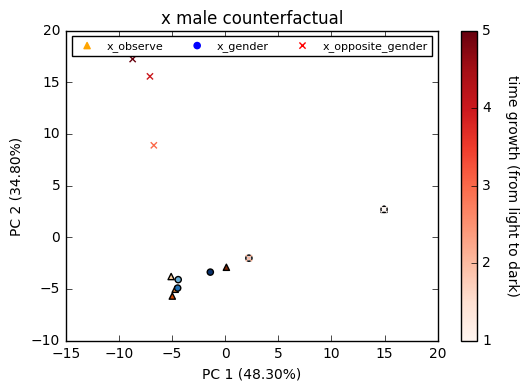

[[ 14.94829851   2.69307967]
 [ -5.08429315  -3.81096414]
 [ -4.70058144  -5.04110111]
 [ -4.97486699  -5.70150797]
 [  0.11319439  -2.91293168]
 [ 14.94829851   2.69307967]
 [  2.23307265  -2.03081303]
 [ -4.41899384  -4.10986936]
 [ -4.46859091  -4.92560748]
 [ -1.39892739  -3.38224599]
 [ 14.94829851   2.69307967]
 [  2.23307265  -2.03081303]
 [ -6.712022     8.88822465]
 [ -7.07763316  15.56062086]
 [ -8.7066885   17.23595918]
 [ -5.08429315  -3.81096414]
 [ -4.70058144  -5.04110111]
 [ -4.97486699  -5.70150797]
 [  0.11319439  -2.91293168]
 [ 12.76490937   1.64831498]]
Y shape: (8, 2)
T 4


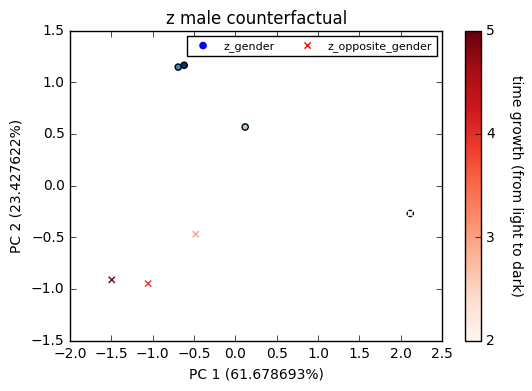

Y shape: (20, 2)
T 5


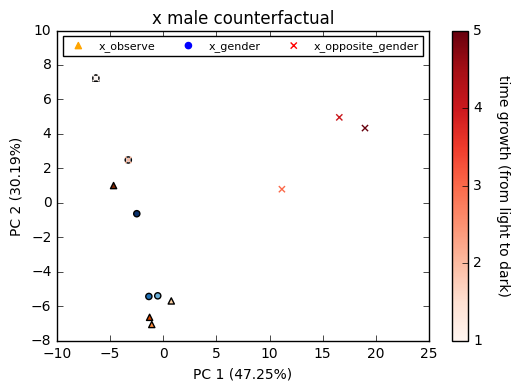

[[ -6.34197017   7.2355051 ]
 [  0.75143041  -5.70271851]
 [ -1.08399664  -7.07063417]
 [ -1.28756734  -6.65374456]
 [ -4.67768489   0.99634446]
 [ -6.34197017   7.2355051 ]
 [ -3.29371224   2.4821786 ]
 [ -0.52104508  -5.40553432]
 [ -1.3563307   -5.44318006]
 [ -2.49385675  -0.6378574 ]
 [ -6.34197017   7.2355051 ]
 [ -3.29371224   2.4821786 ]
 [ 11.16035314   0.78551782]
 [ 16.56113933   4.95611148]
 [ 18.97873497   4.33430969]
 [  0.19142651  -5.86427657]
 [ -1.1031878   -6.07746201]
 [ -1.4208137   -6.78002016]
 [ -3.38374002   1.91896289]
 [ -4.70152646   9.97330892]]
Y shape: (8, 2)
T 4


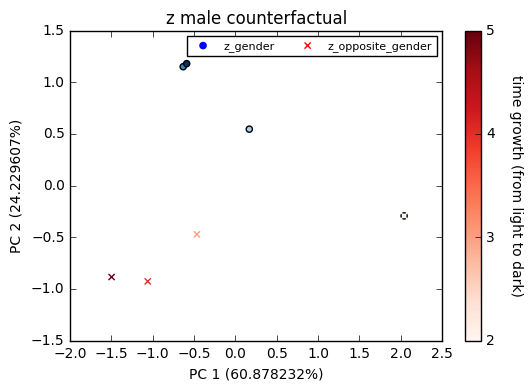

Y shape: (20, 2)
T 5


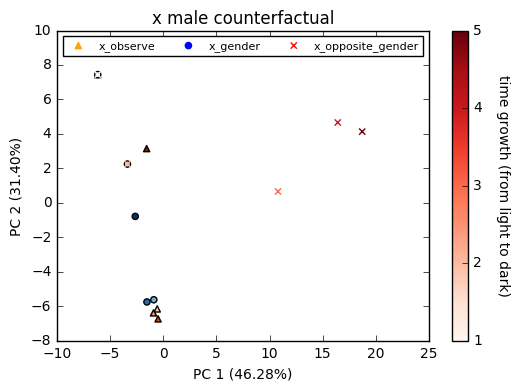

[[ -6.16668967   7.43997105]
 [ -0.57085328  -6.16604342]
 [ -0.92083291  -6.39592928]
 [ -0.48916008  -6.74415093]
 [ -1.56570083   3.1422913 ]
 [ -6.16668967   7.43997105]
 [ -3.3744556    2.2438838 ]
 [ -0.89072665  -5.63498428]
 [ -1.53782745  -5.76126741]
 [ -2.63703717  -0.79272134]
 [ -6.16668967   7.43997105]
 [ -3.3744556    2.2438838 ]
 [ 10.79445168   0.65498651]
 [ 16.41227911   4.65849436]
 [ 18.71612711   4.12931078]
 [ -0.33206424  -5.78615984]
 [ -1.40999494  -6.29495808]
 [ -1.73733773  -7.05520568]
 [ -3.43803908   1.74345307]
 [ -5.14430335   9.4952035 ]]
Y shape: (8, 2)
T 4


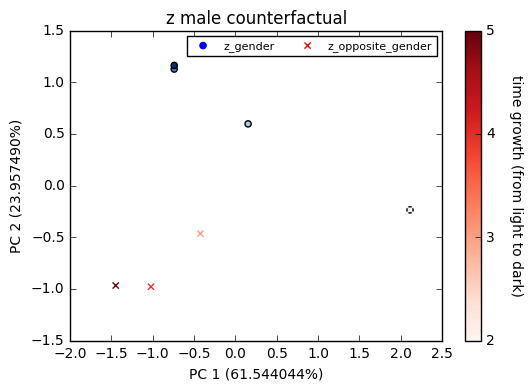

Y shape: (20, 2)
T 5


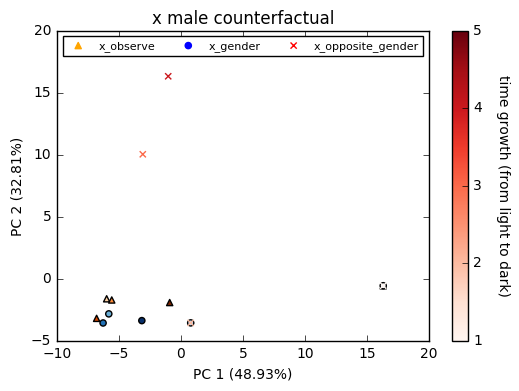

[[ 16.31755581  -0.58345021]
 [ -5.9855926   -1.63546864]
 [ -5.57439775  -1.73216646]
 [ -6.79488766  -3.21313015]
 [ -0.90178078  -1.93848657]
 [ 16.31755581  -0.58345021]
 [  0.79260785  -3.57915703]
 [ -5.81294247  -2.85209372]
 [ -6.2722621   -3.5873034 ]
 [ -3.14872336  -3.39685917]
 [ 16.31755581  -0.58345021]
 [  0.79260785  -3.57915703]
 [ -3.07149477  10.01727272]
 [ -1.02149754  16.30759395]
 [ -1.84067441  18.51453233]
 [ -6.35585545  -2.21558155]
 [ -6.37247333  -3.55710812]
 [ -7.03290043  -4.01962878]
 [ -1.63127081  -3.54004831]
 [ 11.27887032  -4.24285943]]
Y shape: (8, 2)
T 4


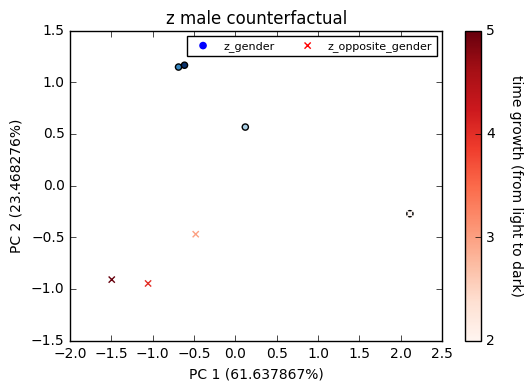

Y shape: (20, 2)
T 5


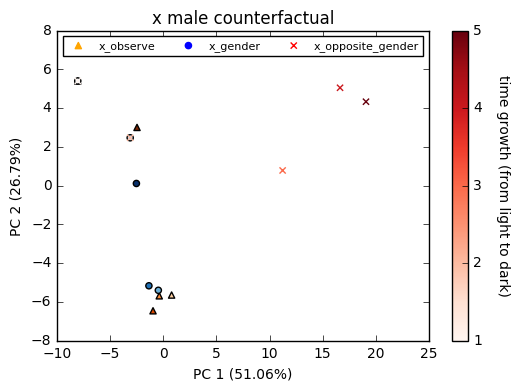

[[ -8.04549451   5.39508731]
 [  0.78332099  -5.65359165]
 [ -0.37987821  -5.69433968]
 [ -0.96585792  -6.46664279]
 [ -2.47081643   2.99761403]
 [ -8.04549451   5.39508731]
 [ -3.11433303   2.46268089]
 [ -0.46594599  -5.40880661]
 [ -1.35248277  -5.1762017 ]
 [ -2.52948968   0.10483774]
 [ -8.04549451   5.39508731]
 [ -3.11433303   2.46268089]
 [ 11.2270396    0.77636528]
 [ 16.63077237   5.04447198]
 [ 19.07117322   4.32557094]
 [  0.30917551  -5.95969744]
 [ -0.96540107  -6.05133765]
 [ -1.27253938  -6.74479518]
 [ -3.39874119   3.00756729]
 [ -3.85517945   9.78836173]]
Y shape: (8, 2)
T 4


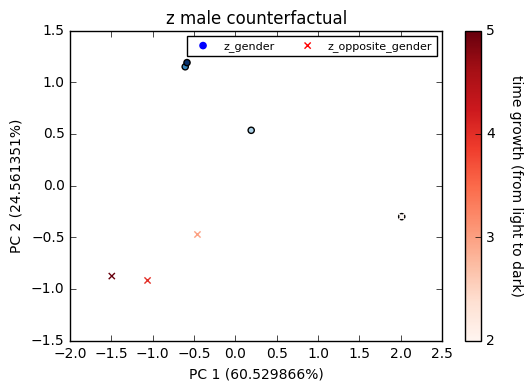

Y shape: (20, 2)
T 5


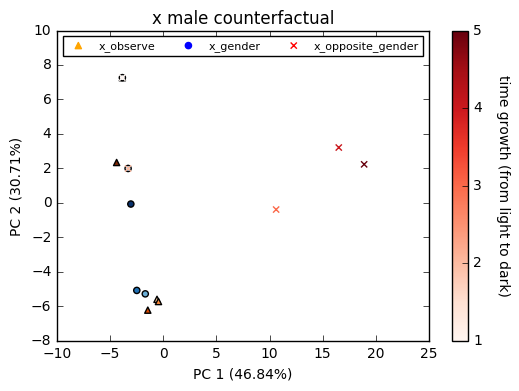

[[ -3.84952957   7.2615347 ]
 [ -0.59116157  -5.60884236]
 [ -0.45202438  -5.73632815]
 [ -1.45703065  -6.23703327]
 [ -4.39015344   2.33633275]
 [ -3.84952957   7.2615347 ]
 [ -3.31015395   1.98899834]
 [ -1.69436157  -5.29153869]
 [ -2.49316729  -5.09181013]
 [ -3.05266564  -0.0759513 ]
 [ -3.84952957   7.2615347 ]
 [ -3.31015395   1.98899834]
 [ 10.61712716  -0.39600857]
 [ 16.51023118   3.2050724 ]
 [ 18.89730015   2.22855265]
 [ -1.00380624  -5.78719307]
 [ -2.18310689  -6.0499084 ]
 [ -2.60631913  -6.65952329]
 [ -3.54412992   2.37183041]
 [ -4.38783515  11.02974826]]
Y shape: (8, 2)
T 4


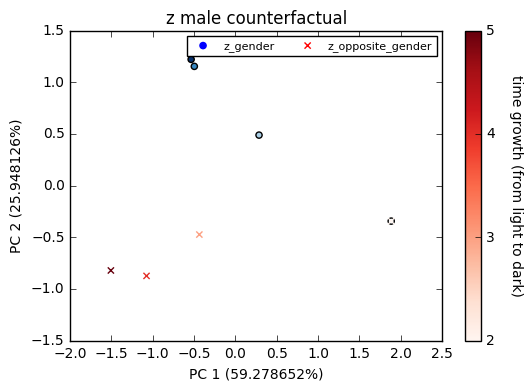

0.635816458408
[ 0.06378708  0.20509878 -0.21573691 -0.09506165  0.00266128  0.22965335
  0.00481608 -0.45226629 -0.03715762 -0.20941039]
0.597714474263
[ 0.32570994 -0.07823332  0.15068081  0.03917446  0.27557257 -0.09501804
 -0.13707558  0.2736944  -0.2047163   0.01549364]
0.57876814434
[ 0.00983833 -0.00777565  0.07543579 -0.13743141  0.10931291  0.53382358
 -0.02647531 -0.02209969  0.07507319 -0.08059226]
0.612561097565
[-0.28711794 -0.17721373  0.20949152  0.09732066 -0.14339591  0.01726338
  0.12476815  0.11849718  0.21205462  0.33555242]
0.559427722999
[-0.03331182 -0.03087601  0.07630519 -0.20684453  0.14421323  0.36854121
 -0.13523128 -0.00402277  0.00404051 -0.29554888]
0.700183150394
[-0.43679493  0.12241974 -0.24521644 -0.22869067  0.00857272  0.05955439
 -0.22515977  0.17675557 -0.29268713  0.02870689]
0.847563330425
[ 0.15436406  0.21716567 -0.13356714 -0.15867015  0.20443317 -0.15643189
  0.04174201  0.6244673   0.38227496 -0.01606854]
0.714060291801
[-0.32964155  0.0278

In [94]:
# For time gender. Looks better.
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-1_0000e-01-uid'

# expt = 'H-time-gender'
# uid = 'DKF_lr-8_0000e-04-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-5_0000e-02-uid'

cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
male_cfac = cfac['male_cfac']
female_cfac = cfac['female_cfac']

plotAllCfac(male_cfac, opposite_example=female_cfac[0])

# Do it with Gaussian and pick those important weights.
cfac = getPKLData(cfac_file)
# for i in xrange(i):
#     dim_vector = cfac['model_weights']['p_emis_W_mu'][i][:10]
#     print dim_vector

trans = cfac['model_weights']['p_trans_W_mu'][:10]
for i in xrange(10):
    print np.linalg.norm(trans[i])
    print trans[i]
# plt.hist(dim_vector)
# plt.show()

Y shape: (20, 2)
T 5


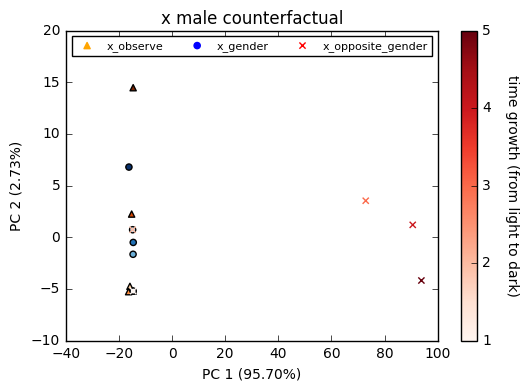

[[-14.61845952  -5.21635865]
 [-15.84600675  -4.75926647]
 [-16.34383944  -5.27502433]
 [-15.20000668   2.23490546]
 [-14.63257189  14.46402198]
 [-14.61845952  -5.21635865]
 [-14.8259903    0.71861696]
 [-14.66465643  -1.65574555]
 [-14.59883065  -0.50803597]
 [-16.22142986   6.78372995]
 [-14.61845952  -5.21635865]
 [-14.8259903    0.71861696]
 [ 72.89432401   3.52745487]
 [ 90.58369527   1.19179462]
 [ 93.84792659  -4.19410487]
 [-14.30293261  15.41785631]
 [-14.61845952  -5.21635865]
 [-15.84600675  -4.75926647]
 [-16.34383944  -5.27502433]
 [-15.20000668   2.23490546]]
Y shape: (8, 2)
T 4


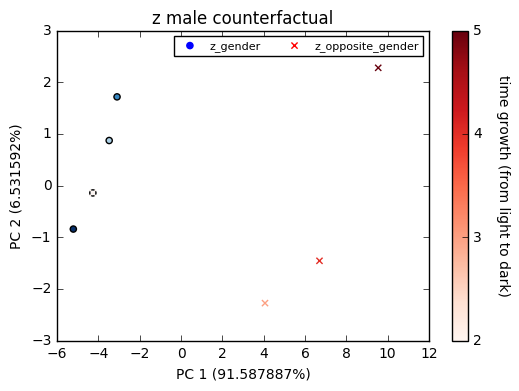

Y shape: (20, 2)
T 5


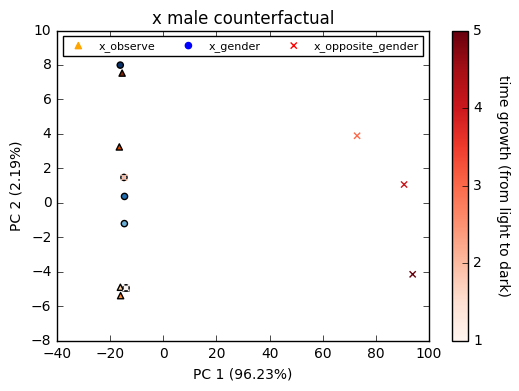

[[-14.01366852  -4.94481177]
 [-16.14173636  -4.90892749]
 [-16.06544676  -5.39580796]
 [-16.5441065    3.23915076]
 [-15.49044424   7.52772012]
 [-14.01366852  -4.94481177]
 [-14.80393842   1.46903431]
 [-14.64585512  -1.21220393]
 [-14.59152836   0.3652474 ]
 [-16.19011413   7.9905367 ]
 [-14.01366852  -4.94481177]
 [-14.80393842   1.46903431]
 [ 72.93432809   3.88899778]
 [ 90.62498739   1.05746253]
 [ 93.85318378  -4.15708443]
 [-14.18425048  14.638712  ]
 [-14.57425345  -4.75721155]
 [-15.82621585  -4.80469454]
 [-16.31303986  -5.2226115 ]
 [-15.19662574   3.64708081]]
Y shape: (8, 2)
T 4


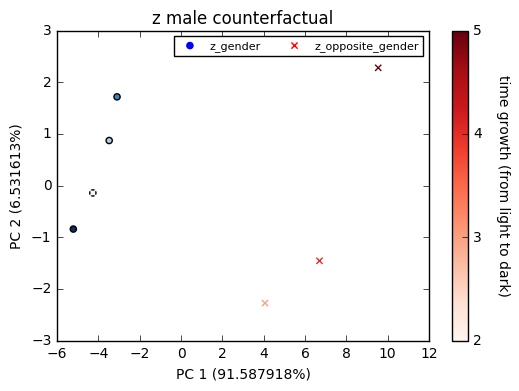

Y shape: (20, 2)
T 5


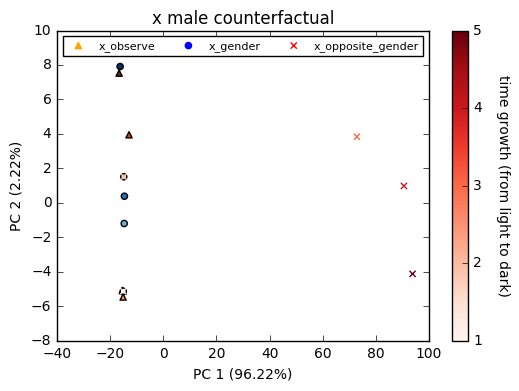

[[-15.06782685  -5.13834094]
 [-15.43849173  -5.09199597]
 [-15.12482544  -5.47463613]
 [-12.8937898    3.94502012]
 [-16.61374814   7.52483115]
 [-15.06782685  -5.13834094]
 [-14.86901808   1.50596938]
 [-14.70251019  -1.20629724]
 [-14.63575616   0.37635926]
 [-16.24689083   7.90925322]
 [-15.06782685  -5.13834094]
 [-14.86901808   1.50596938]
 [ 72.85853412   3.83187367]
 [ 90.55459097   0.97448202]
 [ 93.81466792  -4.13220116]
 [-14.30031168  14.72543954]
 [-14.69123039  -4.56010436]
 [-15.92924423  -4.57121708]
 [-16.42935721  -5.2394265 ]
 [-15.28012053   3.39170353]]
Y shape: (8, 2)
T 4


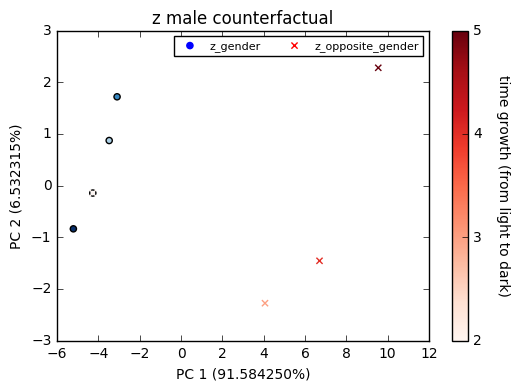

Y shape: (20, 2)
T 5


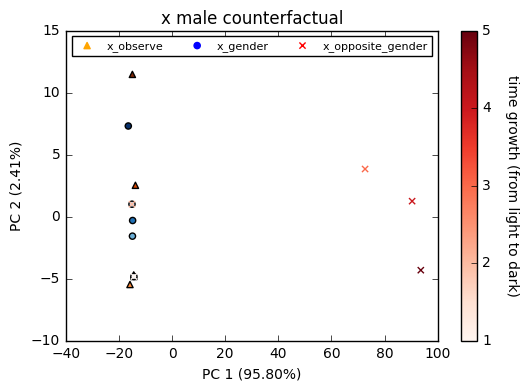

[[-14.35270859  -4.83703043]
 [-14.41388917  -4.71274391]
 [-15.82653326  -5.48528395]
 [-13.78125889   2.51585274]
 [-14.92610082  11.46028006]
 [-14.35270859  -4.83703043]
 [-15.07224338   0.99265766]
 [-14.89776866  -1.58457087]
 [-14.83052791  -0.32329851]
 [-16.45966544   7.2981131 ]
 [-14.35270859  -4.83703043]
 [-15.07224338   0.99265766]
 [ 72.65152255   3.83029013]
 [ 90.35113437   1.23704821]
 [ 93.6212655   -4.32955592]
 [-14.67334071  14.99273917]
 [-15.00892942  -4.49261047]
 [-16.25439488  -4.98729283]
 [-16.74151362  -5.28772806]
 [-15.6073871    2.39453708]]
Y shape: (8, 2)
T 4


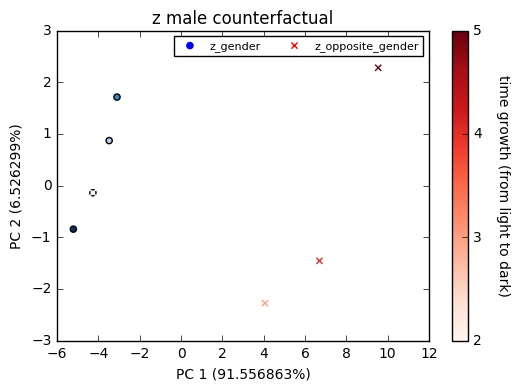

Y shape: (20, 2)
T 5


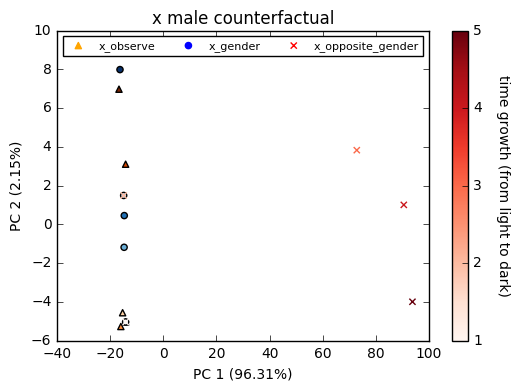

[[-14.17081014  -5.04284087]
 [-15.30664441  -4.56631198]
 [-15.97100886  -5.27844529]
 [-14.17290691   3.09914649]
 [-16.67140498   6.97084135]
 [-14.17081014  -5.04284087]
 [-14.90808825   1.48619213]
 [-14.74395853  -1.18926862]
 [-14.68049392   0.4472088 ]
 [-16.29276316   7.98189434]
 [-14.17081014  -5.04284087]
 [-14.90808825   1.48619213]
 [ 72.82129482   3.82300328]
 [ 90.515533     1.00023421]
 [ 93.77067934  -4.00041746]
 [-14.36331605  14.7023731 ]
 [-14.74266808  -4.68549226]
 [-15.98777638  -4.67765373]
 [-16.48695634  -5.1924868 ]
 [-15.35900262   3.72151292]]
Y shape: (8, 2)
T 4


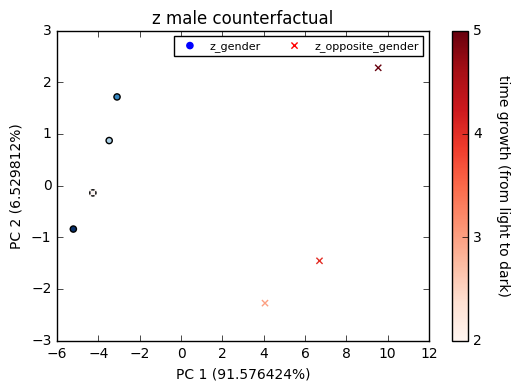

Y shape: (20, 2)
T 5


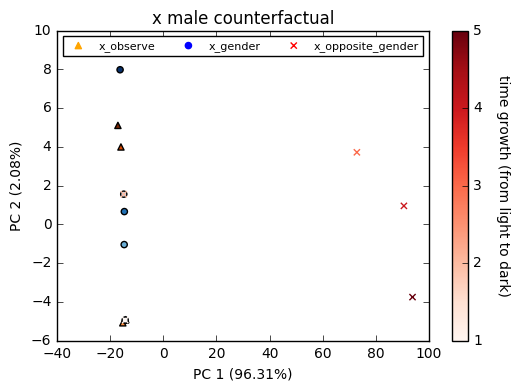

[[-14.34647682  -4.9446286 ]
 [-14.11209135  -4.92311466]
 [-15.23675557  -5.08735961]
 [-15.93733643   3.98906332]
 [-17.07676685   5.10222932]
 [-14.34647682  -4.9446286 ]
 [-14.87664579   1.55284434]
 [-14.71362438  -1.04952675]
 [-14.65521402   0.65374153]
 [-16.25766005   7.97443025]
 [-14.34647682  -4.9446286 ]
 [-14.87664579   1.55284434]
 [ 72.85725463   3.7127565 ]
 [ 90.55387622   0.94845136]
 [ 93.7958863   -3.76011024]
 [-14.23132207  14.78914473]
 [-14.64892103  -4.80363983]
 [-15.88949299  -4.51665505]
 [-16.38380574  -5.07374289]
 [-15.27130465   3.77252913]]
Y shape: (8, 2)
T 4


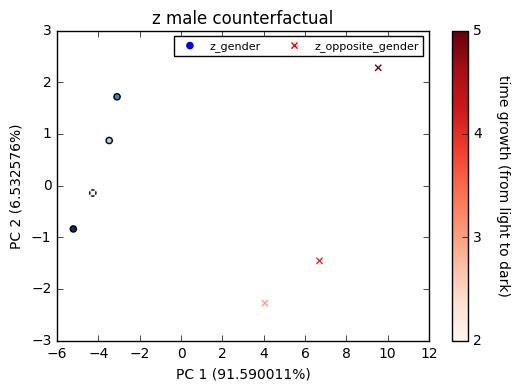

In [137]:
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-0-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
cfac = getPKLData(cfac_file)
female_cfac = cfac['female_cfac']
plotAllCfac(female_cfac, opposite_example=cfac['male_cfac'][0])




In [124]:
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-0-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
cfac = getPKLData(cfac_file)
# male_cfac = cfac['male_cfac']
# plotAllCfac(male_cfac)

def visualizeEmissionConstant(cfac):
    dim_vector = cfac['model_weights']['p_emis_b_mu']
    print dim_vector.shape
    print np.linalg.norm(dim_vector)
    plt.hist(dim_vector)
    plt.show()

def visualizeEmissionWeights(cfac):
    emis = cfac['model_weights']['p_emis_W_mu']
    def visualzeEmissionNodeWeight(x):
        mean, std = np.mean(x), np.std(x)
        print 'mean:', mean, 'std:', std

        plt.hist(x)
        plt.show()
    
    whole_emis = emis.reshape((emis.size,))
    visualzeEmissionNodeWeight(whole_emis)
    
    print 'visualize each node weight...'
    for i in xrange(emis.shape[0]):
        visualzeEmissionNodeWeight(emis[i])

# visualizeEmissionWeights(cfac)

def pick2stdevWeights(cfac):
    emis = cfac['model_weights']['p_emis_W_mu']

    def do(x, names, total_nodes):
        mean, std = np.mean(x), np.std(x)
        lower, upper = mean - 2*std, mean + 2*std
        significant_index = [(i, value) for i, value in enumerate(x) if value < lower or value > upper]
        print len(significant_index)
        
        for i, v in significant_index:
            print names[i], v
            total_nodes[i] = 1
        print '================'

    names = np.loadtxt('../../expt-mouse-puberty/data/H_name_id.csv', dtype='S20')
    
    total_nodes = {}
    for i in xrange(emis.shape[0]):
        indexes = do(emis[i], names, total_nodes)
    print 'all nodes:', len(total_nodes)
        
pick2stdevWeights(cfac)

6
Fshb 0.453908038929
Gnrhr 0.587390137833
Hnf4a 0.578233841545
Lep -1.01798029205
Impg1 0.565660224748
Tnni3k 0.730854813381
14
Dlk1 0.265768112515
Fgf8 -0.451873376108
Gnrhr -0.472539586888
Hesx1 -0.483431123745
Hnf4a -0.53082551495
Lep 0.401782296212
Lhx3 -0.411694240542
Lin28a -0.679599932506
Mkrn3 -0.40732864582
Odf3 -0.478188137526
Pou1f1 -0.573488086339
Prok2 -0.382816211987
Il20rb -0.389048345015
Impg1 -0.65575856871
15
Dlk1 -0.412482962717
Fgf8 0.669382433348
Gnrhr 0.495670920119
Hesx1 0.661188054645
Hnf4a 0.612994453425
Lin28a 0.835377493492
Mkrn3 0.606184104752
Odf3 0.63275252545
Pou1f1 0.760751984502
Prok2 0.491854151551
Sec16b 0.497758109374
Fam83b 0.576483154678
Il20rb 0.533219496316
Impg1 0.608615947711
Tnni3k 0.517597713934
13
Fgf8 1.05200888957
Fshb 0.654037166185
Gapdh -0.458828044074
Gnrhr 0.665620880629
Hesx1 0.893751934159
Hnf4a 0.838732987944
Lep -0.463815792595
Lhx3 0.763866027902
Lin28a 0.742476981657
Prok2 0.92020574902
H2Q10 0.703447211862
Impg1 0.838171949655

In [133]:
# ds 2
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-2-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-0-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
cfac = getPKLData(cfac_file)

# visualizeEmissionConstant(cfac)
# visualizeEmissionWeights(cfac)
pick2stdevWeights(cfac)

12
Fgf8 1.57190846551
Gnrhr 1.2565481373
Hesx1 1.27672789035
Hnf4a 1.52702033606
Lep -1.06952028489
Lhx3 1.10954044232
Lin28a 1.47583797523
Mkrn3 1.18992010669
Pou1f1 1.27402593063
Il20rb 1.12540147219
Impg1 1.54036756663
Tnni3k 1.57501736992
14
Fgf8 -1.80561510933
Fshb -2.19929283758
Gnrhr -1.99332825408
Hesx1 -2.0856994461
Hnf4a -2.00747936883
Lep -2.94309697354
Lhx3 -1.89523668069
Lin28a -1.63985698807
Odf3 -1.57771959243
Pou1f1 -1.96238102649
Prok2 -1.82365659627
Impg1 -1.71470182867
Rdh8 -1.99715731878
Vdr -1.69158992815
all nodes: 17


In [153]:
expt = 'H-time-gender-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-2-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-0-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
cfac = getPKLData(cfac_file)

def actionWeights(time):
    male_time_2 = cfac['model_weights']['p_action_W'][time]
    female_time_2 = cfac['model_weights']['p_action_W'][5+time]
    print 'time {}:'.format(time), np.linalg.norm(male_time_2), np.linalg.norm(female_time_2)
    print male_time_2
    print female_time_2

for i in xrange(5):
    actionWeights(i)
cfac['model_weights']['p_trans_W_mu'][:10]

time 0: 1.28137915041 1.29014123393
[ 0.30989676  0.36080344 -0.45829929  0.28556435  0.51204378 -0.40475796
  0.42685712 -0.40974656 -0.34684807 -0.47719127]
[ 0.27606988  0.38359512 -0.46578343  0.23073967  0.36883194 -0.45300472
  0.39735839 -0.42721424 -0.44195052 -0.54215623]
time 1: 1.29563152127 1.30471650428
[ 0.28821803  0.33181908 -0.49849512  0.37234586  0.47762984 -0.47861177
  0.31345198 -0.30846683 -0.37452498 -0.55450546]
[ 0.30623527  0.40350121 -0.48134521  0.39618294  0.56576212 -0.31564741
  0.4075196  -0.31438895 -0.32937493 -0.51372873]
time 2: 1.29355307606 1.3034167566
[ 0.32004745  0.3933503  -0.42576768  0.38840919  0.44588759 -0.34059513
  0.37765452 -0.37161713 -0.33778937 -0.61183351]
[ 0.43403231  0.42590431 -0.24365439  0.22566182  0.43021773 -0.31275522
  0.57191446 -0.38753742 -0.49395668 -0.46331228]
time 3: 1.30896188903 2.08101587681
[ 0.38725994  0.42198555 -0.33482179  0.15850801  0.36617982 -0.39646464
  0.55334855 -0.45527706 -0.52027392 -0.415547

array([[-0.2604118 ,  0.68916439],
       [-0.43011944,  0.60846666],
       [ 0.69478745, -0.22979088],
       [-0.35435159,  0.61112799],
       [-0.80382405,  0.22923103],
       [ 0.57079805, -0.46090497],
       [-0.58830612,  0.3053547 ],
       [ 0.45667954, -0.49344937],
       [ 0.60226748, -0.42653289],
       [ 0.95625303, -0.20942372]])

In [156]:
expt = 'male_H-time-linear'
uid = 'DKF_lr-5_0000e-03-vm-R-inf-structured-dh-10-ds-5-nl-relu-bs-256-ep-500-rs-20-ar-2_0000e+01-rv-5_0000e-02-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)
cfac = getPKLData(cfac_file)

pick2stdevWeights(cfac)

17
Actb -0.476440366359
Fgf8 0.74125617226
Fshb 0.825302366532
Gapdh -0.453460991424
Gnrhr 0.795998187262
Hesx1 0.863404513946
Hnf4a 0.755117258223
Lep 0.640390706458
Lhx3 0.749606415691
Lin28a 0.699562593234
Odf3 0.681845684954
Pou1f1 0.889339881795
Prok2 0.63467983808
Impg1 0.763581595093
Prdm13 0.659103219064
Rdh8 0.653986115269
Tnni3k 0.670237841156
14
Actb -0.422717813748
Fgf8 0.773175706487
Fshb 0.600435624046
Gnrhr 0.674501391999
Hesx1 0.707386789755
Hnf4a 0.649839153842
Lhx3 0.691096203643
Lin28a 0.586588713794
Odf3 0.619529294661
Pou1f1 0.7464729956
Prok2 0.60236633349
Impg1 0.653461950118
Ntrk2 -0.395047601129
Tnni3k 0.548742954691
16
Actb -0.439532718539
Fgf8 0.716278941191
Fshb 0.706435906502
Gapdh -0.429772588468
Gnrhr 0.681162898474
Hesx1 0.736494818236
Hnf4a 0.803863806914
Lhx3 0.631302923592
Lin28a 0.684145602845
Odf3 0.63561961566
Pou1f1 0.722830281819
Prok2 0.624481768921
Impg1 0.612240826869
Rdh8 0.744645166733
Tnni3k 0.661854218378
Vdr 0.660596503665
11
Cbx7 0.46742